/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_95586/3940303224.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prs_df = df.groupby('SampleID').apply(lambda x: np.sum(x['Dosage'] * x[phenotype]))
/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_95586/3940303224.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prs_df = df.groupby('SampleID').apply(lambda x: np.sum(x['Dosage'] *

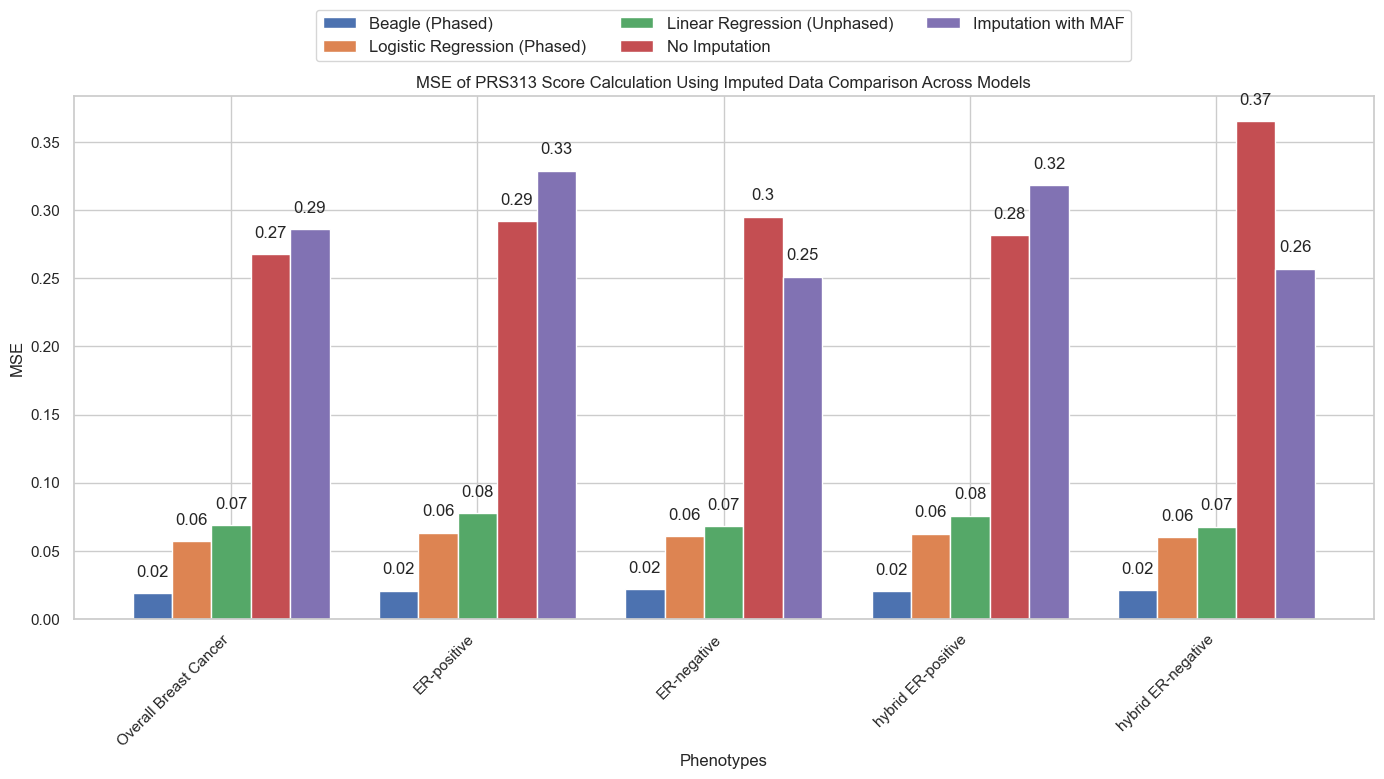

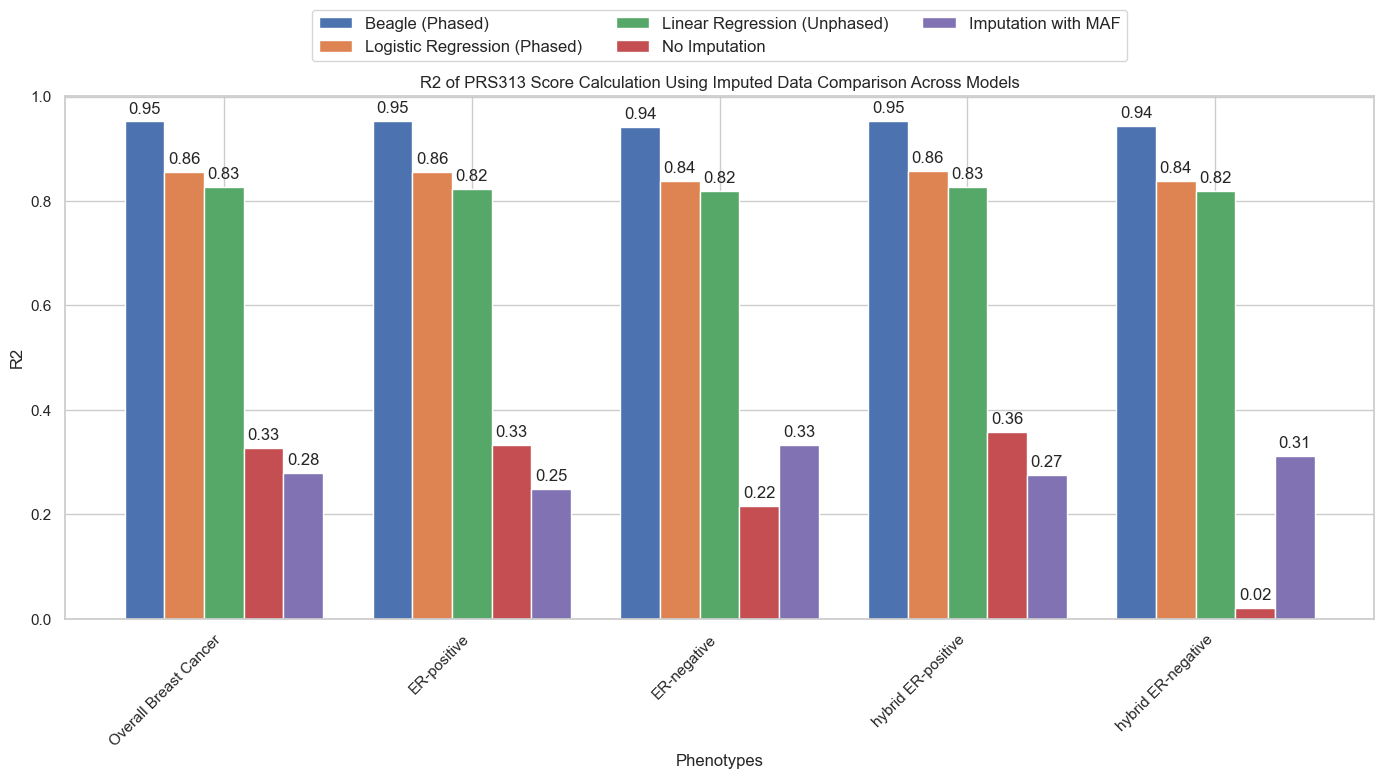

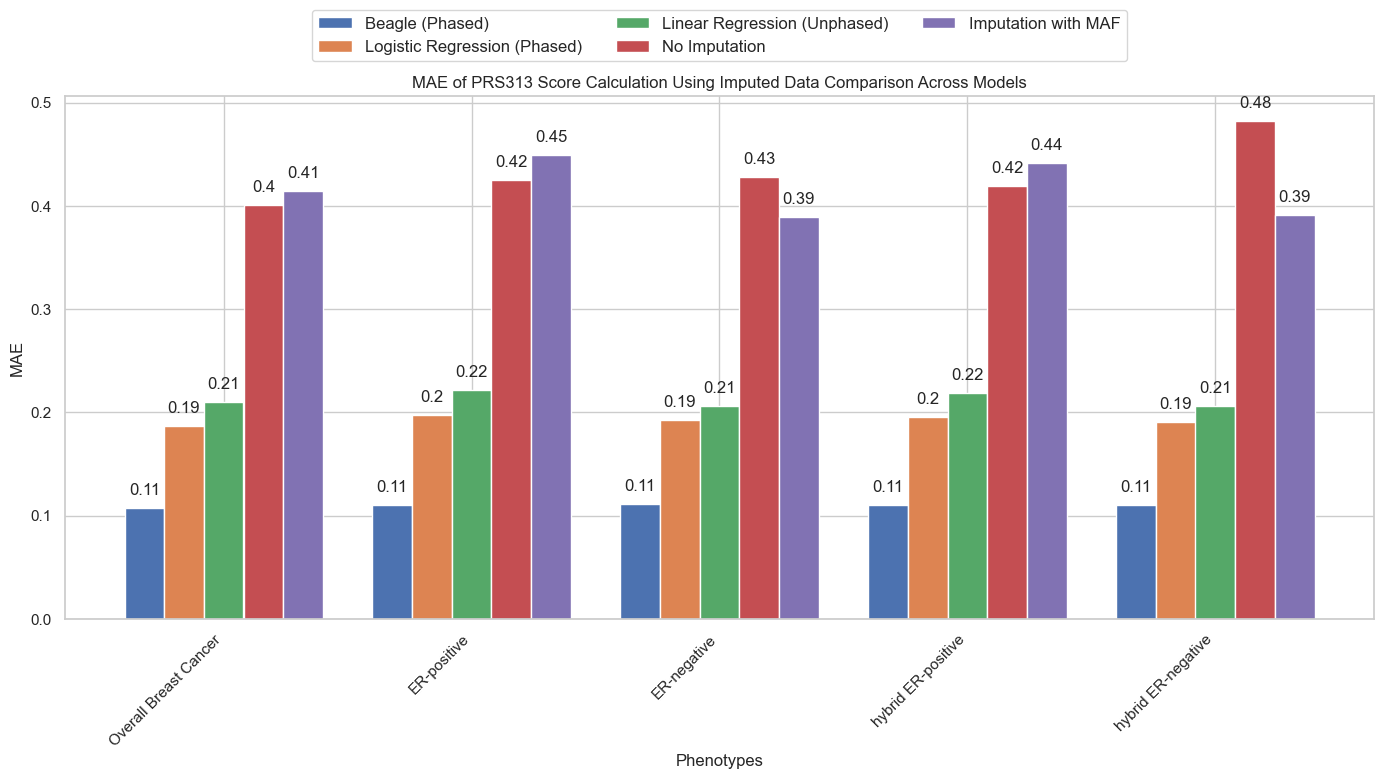

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Load the PRS313 data
prs313_df = pd.read_excel('../../../Data/PRS313_with_23andMe.xlsx')

# Format PRS313 SNP names to match the genotype data format
prs313_df['SNP'] = prs313_df.apply(lambda row: f"{row['Chromosome']}:{row['Positionb']}:{row['Reference Allele']}:{row['Effect Allele']}", axis=1)

# Function to format SNP names
def format_snp_names_and_sort_by_sampleID(df):
    df.columns = ['SampleID'] + [col.split('_PRS313')[0].replace('chr', '').replace('_', ':') for col in df.columns[1:]]
    df = df.sort_values(by=['SampleID'])
    df = df.reset_index(drop=True)
    return df

# Merge the true labels and predictions with the PRS313 data
def merge_with_prs313(df, prs313_df, true_labels_df):
    df = df.melt(id_vars=["SampleID"], var_name="SNP", value_name="Dosage")
    df['Dosage'] = df['Dosage'].round()  # Round the dosage values
    
    # Identify known SNPs present in 23andMe
    known_snps = prs313_df[prs313_df['in_23andMe'] == True]['SNP']
    # print("Known SNPs in 23andMe:")
    # print(known_snps)
    
    # Prepare the known dosage dataframe
    known_df = true_labels_df.melt(id_vars=["SampleID"], var_name="SNP", value_name="Known_Dosage")
    df = pd.merge(df, known_df, on=["SampleID", "SNP"], how="left")
    
    # Track and print replacements
    replaced_values = df[df['SNP'].isin(known_snps) & df['Known_Dosage'].notnull()]
    # print("\nReplaced Values:")
    # print(replaced_values[['SampleID', 'SNP', 'Dosage', 'Known_Dosage']])
    
    df['Dosage'] = np.where(df['SNP'].isin(known_snps), df['Known_Dosage'], df['Dosage'])
    df = df.drop(columns=['Known_Dosage'])

    merged_df = pd.merge(df, prs313_df, on="SNP")
    return merged_df

# Calculate PRS
def calculate_prs(df, phenotype):
    prs_df = df.groupby('SampleID').apply(lambda x: np.sum(x['Dosage'] * x[phenotype]))
    return prs_df.reset_index(name=phenotype + '_PRS')

# Function to calculate performance metrics
def calculate_metrics(true, pred):
    return {
        'MSE': mean_squared_error(true, pred),
        'R2': r2_score(true, pred),
        'MAE': mean_absolute_error(true, pred)
    }

# Visualize the performance
def plot_performance(metric_name, metrics, phenotypes):
    models = list(metrics[phenotypes[0]].keys())
    x = np.arange(len(phenotypes))
    total_width = 0.8
    width = total_width / len(models)

    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, model in enumerate(models):
        metric_values = [metrics[phenotype][model][metric_name] for phenotype in phenotypes]
        bars = ax.bar(x + (i - len(models) / 2) * width + width / 2, metric_values, width, label=model)
        
        # Add text labels on bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

    ax.set_xlabel('Phenotypes')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} of PRS313 Score Calculation Using Imputed Data Comparison Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(phenotypes, rotation=45, ha="right")
    
    # Move legend to the top and reduce font size
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize='medium')

    plt.tight_layout()
    plt.show()


# Main function to process and plot metrics
def process_and_plot_metrics(true_labels_df_path, prs313_df, imputed_genotypes_paths, phenotypes):
    # Load the true labels
    true_labels_df = pd.read_csv(true_labels_df_path)
    true_labels_df = format_snp_names_and_sort_by_sampleID(true_labels_df)

    # Merge true labels with PRS313
    true_merged = merge_with_prs313(true_labels_df, prs313_df, true_labels_df)

    # Calculate true PRS
    true_prs = true_merged[['SampleID']].drop_duplicates().reset_index(drop=True)
    for p in phenotypes:
        true_prs = true_prs.merge(calculate_prs(true_merged, p), on='SampleID')
    true_prs.columns = ['SampleID'] + ['True_' + p + '_PRS' for p in phenotypes]

    # Process each imputed genotype
    merged_prs = true_prs.copy()
    model_names = imputed_genotypes_paths.keys()

    for model_name, path in imputed_genotypes_paths.items():
        df = pd.read_csv(path)
        df = format_snp_names_and_sort_by_sampleID(df)
        merged_df = merge_with_prs313(df, prs313_df, true_labels_df)
        
        model_prs = merged_df[['SampleID']].drop_duplicates().reset_index(drop=True)
        for p in phenotypes:
            model_prs = model_prs.merge(calculate_prs(merged_df, p), on='SampleID')
        model_prs.columns = ['SampleID'] + [model_name + '_' + p + '_PRS' for p in phenotypes]

        merged_prs = merged_prs.merge(model_prs, on='SampleID')

    # Calculate performance metrics
    metrics = {}
    for p in phenotypes:
        metrics[p] = {}
        for model_name in model_names:
            metrics[p][model_name] = calculate_metrics(merged_prs['True_' + p + '_PRS'], merged_prs[model_name + '_' + p + '_PRS'])

    # Plot performance metrics
    plot_performance('MSE', metrics, phenotypes)
    plot_performance('R2', metrics, phenotypes)
    plot_performance('MAE', metrics, phenotypes)

# Example usage
imputed_genotypes_paths = {
    'Beagle (Phased)': '../../../Data/model_results_unphased_all_PRS/beagle/combined_imputed_dosages.csv',
    'Logistic Regression (Phased)': '../../../Data/model_results/logistic_regression/all_predictions.csv',
    'Linear Regression (Unphased)': '../../../Data/model_results_unphased_all_PRS/linear_regression/all_predictions.csv',
    'No Imputation': './all_chr_missing_values_y_test.csv',
    'Imputation with MAF': './all_chr_simple_imputation_values_y_test.csv',
}

phenotypes = ['Overall Breast Cancer', 'ER-positive', 'ER-negative', 'hybrid ER-positive', 'hybrid ER-negative']

process_and_plot_metrics('../../../scripts/Python/benchmarking/all_chr_true_labels_y_test.csv', prs313_df, imputed_genotypes_paths, phenotypes)
